<a href="https://www.kaggle.com/code/gamzebayir/house-prices-predictions?scriptVersionId=94144146" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-dataset/sample_submission.csv
/kaggle/input/house-prices-dataset/data_description.txt
/kaggle/input/house-prices-dataset/train.csv
/kaggle/input/house-prices-dataset/test.csv


In [2]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_validate
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,VotingClassifier
from sklearn.preprocessing import MinMaxScaler,LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression,LinearRegression, Ridge, Lasso, ElasticNet
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,VotingRegressor
from xgboost import XGBRegressor,XGBClassifier
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [3]:
test=pd.read_csv("../input/house-prices-dataset/test.csv")
train=pd.read_csv("../input/house-prices-dataset/train.csv")
sample=pd.read_csv("../input/house-prices-dataset/sample_submission.csv")

In [4]:
df=pd.concat([train,test],sort=False)

In [5]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# pd.set_option('display.width', None)
# pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [7]:
def dataframe_check(dataframe):
    print("############# Data set Info #################")
    print(dataframe.info())
    print("############# Shape ######################")
    print(dataframe.shape)
    print("############## NA Values ##################")
    print(dataframe.isnull().sum())
    print("############# Data set Head ###############")
    print(dataframe.head())
    print("############# Data set Tail ###############")
    print(dataframe.tail())
    print("############# Data set Describe ############")
    print(dataframe.describe().T)
    print("##########################################")

def grab_col_names(dataframe,low_limit=0, cat_th=10, car_th=20):
    """

    It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be retrieved
        low_limit:int, optional
                Minimum class threshold value for numeric but categorical variables
        cat_th: int, optional
                Class threshold value for numeric but categorical variables
        car_th: int, optional
                Class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numerical variable list
        cat_but_car: list
                Categorical view cardinal variable list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = the total number of variables
        num_but_cat is inside cat_cols.
        The sum of 3 lists with return is equal to the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O" and dataframe[col].nunique()>low_limit]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("\n")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    print("\n")
    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

def outlier_thresholds(dataframe, col_name, q1=0.20, q3=0.80):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    #dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    #dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    dataframe=dataframe[(dataframe[variable]>low_limit)&(dataframe[variable]<up_limit)]

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

def apply_values_with_null(df, column):
    df[column] = df[column].apply(lambda x:"none" if pd.isnull(x) else x)

def missing_value_apply(dataframe,na_cols):
    dataframe[na_cols]= dataframe[na_cols].apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O") else x)
    dataframe[na_cols]= dataframe[na_cols].apply(lambda x: x.fillna(0) if x.dtype != "O" else x)

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")



In [8]:
def feature_extract(dataframe):
    dataframe.loc[(dataframe['YearBuilt'] < 1925), 'New_YearBuilt'] = 'very_old'
    dataframe.loc[(dataframe['YearBuilt'] >= 1925) & (dataframe['YearBuilt'] < 1955), 'New_YearBuilt'] = 'old'
    dataframe.loc[(dataframe['YearBuilt'] >= 1955) & (dataframe['YearBuilt'] < 1985), 'New_YearBuilt'] = 'like_old'
    dataframe.loc[(dataframe['YearBuilt'] >= 1985) & (dataframe['YearBuilt'] < 2010) , 'New_YearBuilt'] = 'like_new'  
    dataframe.loc[(dataframe['YearBuilt'] >= 2010), 'New_YearBuilt'] = 'new'  
    
    
    dataframe[na_cols]= dataframe[na_cols].apply(lambda x: x.fillna(0) if x.dtype != "O" else x)
    
    dataframe["TotalBath_"]=dataframe["FullBath"]+dataframe["HalfBath"]
    dataframe["TotalBath_Bsmnt"]=dataframe["BsmtFullBath"]+dataframe["BsmtHalfBath"]
    dataframe["TotalBath_abvgrnd"]=dataframe["BedroomAbvGr"]+dataframe["KitchenAbvGr"]
    dataframe["TotalBath_condition"]=dataframe["Condition1"]+dataframe["Condition2"]
    dataframe["Year_"]=dataframe["YearBuilt"]-dataframe["GarageYrBlt"]
    dataframe["Year_2"]=dataframe["YrSold"]-dataframe["YearBuilt"]
    #dataframe["GG"]=dataframe["GarageArea"]/dataframe["GarageCars"]
    dataframe["GG_"]=dataframe["TotRmsAbvGrd"]+dataframe["GrLivArea"]+dataframe["GarageArea"]
    dataframe["T_"]=dataframe["TotalBsmtSF"]+dataframe["1stFlrSF"]+dataframe["2ndFlrSF"]
    dataframe["T2_"]=dataframe["TotalBsmtSF"]+dataframe["1stFlrSF"]
    dataframe["T3_"]=dataframe["1stFlrSF"]+dataframe["2ndFlrSF"]

In [9]:
def MM_Scaler(dataframe,col):
    mm = MinMaxScaler()
    dataframe[f"{col}_scaler"] = mm.fit_transform(dataframe[[col]])


In [10]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [11]:
dataframe_check(df)

############# Data set Info #################
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  Overal

In [12]:
df.astype({'BedroomAbvGr': 'int64','HalfBath': 'int64','FullBath': 'int64','MoSold': 'int64'}).dtypes
df.astype({'TotRmsAbvGrd': 'int64','YearRemodAdd': 'int64','YearBuilt': 'int64'}).dtypes
df.astype({'KitchenAbvGr': 'int64','YrSold': 'int64'}).dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1       float64
BsmtFinType2      object
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
Heating           object


In [13]:
cat_cols, num_cols, cat_but_car =grab_col_names(df,low_limit=8,cat_th=11,car_th=25)
cat_cols.append('MSSubClass')
num_cols.remove('MSSubClass')

Observations: 2919
Variables: 81
cat_cols: 45
num_cols: 36
cat_but_car: 0
num_but_cat: 2


In [14]:
for col in cat_cols:
    cat_summary(df, col)

for col in num_cols:
    num_summary(df, col)

         MSZoning      Ratio
RL           2265  77.595067
RM            460  15.758822
FV            139   4.761905
RH             26   0.890716
C (all)        25   0.856458


      Street    Ratio
Pave    2907  99.5889
Grvl      12   0.4111


      Alley     Ratio
Grvl    120  4.110997
Pave     78  2.672148


     LotShape      Ratio
Reg      1859  63.686194
IR1       968  33.162042
IR2        76   2.603631
IR3        16   0.548133


     LandContour      Ratio
Lvl         2622  89.825283
HLS          120   4.110997
Bnk          117   4.008222
Low           60   2.055498


        Utilities      Ratio
AllPub       2916  99.897225
NoSeWa          1   0.034258


         LotConfig      Ratio
Inside        2133  73.072970
Corner         511  17.505995
CulDSac        176   6.029462
FR2             85   2.911956
FR3             14   0.479616


     LandSlope      Ratio
Gtl       2778  95.169579
Mod        125   4.282288
Sev         16   0.548133


         Neighborhood      Ratio
NAmes    

In [15]:
for i in num_cols:
    low, up = outlier_thresholds(df, i)
    if ((df[i] < low) | (df[i] > up)).any():
        print(f"\nIndices: {df[(df[i] < low) | (df[i] > up)].index}\n")
        print(df[(df[i] < low) | (df[i] > up)].head())
        replace_with_thresholds(df, i)




Indices: Int64Index([ 159,  171,  197,  231,  277,  313,  446,  807,  909,  934, 1107,
            1127, 1151, 1173, 1182, 1211, 1298, 1337,  519,  537,  780,  799,
             804,  835, 1053, 1130, 1139, 1201, 1369, 1439, 1456],
           dtype='int64')

      Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
159  160          60       RL        134.0    19378   Pave   NaN      IR1   
171  172          20       RL        141.0    31770   Pave   NaN      IR1   
197  198          75       RL        174.0    25419   Pave   NaN      Reg   
231  232          60       RL        174.0    15138   Pave   NaN      IR1   
277  278          20       RL        140.0    19138   Pave   NaN      Reg   

    LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
159         HLS    AllPub    Corner       Gtl      Gilbert       Norm   
171         Lvl    AllPub    Corner       Gtl        NAmes       Norm   
197         Lvl    AllPub    Corner       Gtl        NAmes

In [16]:
for col in cat_cols:
    target_summary_with_cat(df,'SalePrice',col)

            TARGET_MEAN
MSZoning               
C (all)    74528.000000
FV        214014.061538
RH        131558.375000
RL        191004.994787
RM        126316.830275


          TARGET_MEAN
Street               
Grvl    130190.500000
Pave    181130.538514


         TARGET_MEAN
Alley               
Grvl   122219.080000
Pave   168000.585366


            TARGET_MEAN
LotShape               
IR1       206101.665289
IR2       239833.365854
IR3       216036.500000
Reg       164754.818378


               TARGET_MEAN
LandContour               
Bnk          143104.079365
HLS          231533.940000
Low          203661.111111
Lvl          180183.746758


            TARGET_MEAN
Utilities              
AllPub     180950.95682
NoSeWa     137500.00000


             TARGET_MEAN
LotConfig               
Corner     181623.425856
CulDSac    223854.617021
FR2        177934.574468
FR3        208475.000000
Inside     176938.047529


             TARGET_MEAN
LandSlope               
Gtl        179956.7

In [17]:
na_cols=missing_values_table(df, True)

              n_miss  ratio
PoolQC          2909  99.66
MiscFeature     2814  96.40
Alley           2721  93.22
Fence           2348  80.44
SalePrice       1459  49.98
FireplaceQu     1420  48.65
LotFrontage      486  16.65
GarageCond       159   5.45
GarageYrBlt      159   5.45
GarageFinish     159   5.45
GarageQual       159   5.45
GarageType       157   5.38
BsmtExposure      82   2.81
BsmtCond          82   2.81
BsmtQual          81   2.77
BsmtFinType2      80   2.74
BsmtFinType1      79   2.71
MasVnrType        24   0.82
MasVnrArea        23   0.79
MSZoning           4   0.14
Functional         2   0.07
BsmtHalfBath       2   0.07
BsmtFullBath       2   0.07
Utilities          2   0.07
KitchenQual        1   0.03
TotalBsmtSF        1   0.03
BsmtUnfSF          1   0.03
GarageCars         1   0.03
GarageArea         1   0.03
BsmtFinSF2         1   0.03
BsmtFinSF1         1   0.03
Exterior2nd        1   0.03
Exterior1st        1   0.03
SaleType           1   0.03
Electrical         1

In [18]:
columns=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']

for column in columns:
    apply_values_with_null(df,column)

In [19]:
na_cols=missing_values_table(df, True)

missing_value_apply(df,na_cols)

feature_extract(df)



              n_miss  ratio
Alley           2721  93.22
SalePrice       1459  49.98
FireplaceQu     1420  48.65
LotFrontage      486  16.65
GarageYrBlt      159   5.45
MasVnrType        24   0.82
MasVnrArea        23   0.79
MSZoning           4   0.14
BsmtFullBath       2   0.07
BsmtHalfBath       2   0.07
Functional         2   0.07
Utilities          2   0.07
BsmtFinSF1         1   0.03
BsmtFinSF2         1   0.03
BsmtUnfSF          1   0.03
Exterior2nd        1   0.03
Electrical         1   0.03
KitchenQual        1   0.03
Exterior1st        1   0.03
GarageCars         1   0.03
GarageArea         1   0.03
SaleType           1   0.03
TotalBsmtSF        1   0.03


In [20]:
na_cols=missing_values_table(df, True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [21]:
df[df["New_YearBuilt"].isnull()]["YearBuilt"]

Series([], Name: YearBuilt, dtype: int64)

In [22]:

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]

for col in binary_cols:
    label_encoder(df, col)

In [23]:
for column in num_cols:
    MM_Scaler(df,col)

In [24]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
one_hot_encoder(df, ohe_cols)

cat_cols, num_cols, cat_but_car =grab_col_names(df,low_limit=8,cat_th=11,car_th=25)
cat_cols.append('MSSubClass')
num_cols.remove('MSSubClass')
#cat_cols.remove('MSSubClass')

Observations: 2919
Variables: 93
cat_cols: 44
num_cols: 49
cat_but_car: 0
num_but_cat: 3


In [25]:
df = pd.get_dummies(df[cat_cols + num_cols], drop_first=True)
#imputer = KNNImputer(n_neighbors=5)
#df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
#sample.head()
df.head(3)
train = df[:len(train)]
test = df[len(train):]
test=test.drop("SalePrice",axis=1)

In [26]:
y = train["SalePrice"]
X = train.drop(["SalePrice"],axis=1)

models = [("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor())]
         



In [27]:
for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=15, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 31957.5905 (Ridge) 
RMSE: 39558.4491 (Lasso) 
RMSE: 34505.6767 (ElasticNet) 
RMSE: 43759.4987 (KNN) 
RMSE: 39683.2751 (CART) 
RMSE: 28206.888 (RF) 
RMSE: 80634.7297 (SVR) 
RMSE: 25521.4564 (GBM) 
RMSE: 28784.1127 (XGBoost) 
RMSE: 28570.8405 (LightGBM) 


In [28]:
cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [5, 8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [8, 15, 20],
             "n_estimators": [200, 500, 1000]}

xgboost_params = {"learning_rate": [0.1, 0.01, 0.01],
                  "max_depth": [5, 8, 12, 20],
                  "n_estimators": [100, 200, 300, 500],
                  "colsample_bytree": [0.5, 0.8, 1]}

lightgbm_params = {"learning_rate": [0.01, 0.1, 0.001],
                   "n_estimators": [300, 500, 1500],
                   "colsample_bytree": [0.5, 0.7, 1]}

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.5, 0.7]}



In [29]:
GBM_model = GradientBoostingRegressor()
print(f"########## GBM ##########")
rmse = np.mean(np.sqrt(-cross_val_score(GBM_model, X, y, cv=15, scoring="neg_mean_squared_error")))
print(f"RMSE: {round(rmse, 4)} (GBM) ")
gs_best = GridSearchCV(GBM_model, gbm_params, cv=3, n_jobs=-1, verbose=False).fit(X, y)

final_model = GBM_model.set_params(**gs_best.best_params_)
rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=15, scoring="neg_mean_squared_error")))
print(f"RMSE (After): {round(rmse, 4)} (GBM) ")

print(f"GBM best params: {gs_best.best_params_}", end="\n\n")

########## GBM ##########
RMSE: 25473.741 (GBM) 
RMSE (After): 25086.6007 (GBM) 
GBM best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.7}



In [30]:
final_model.fit(X,y)
predictions = final_model.predict(test)

In [31]:
submission = pd.DataFrame({'Id':test['Id'],'SalePrice':predictions})
submission["Id"]=submission["Id"].astype(int)
submission.head()

,Id,SalePrice
0,1461,123433.145425
1,1462,160657.198818
2,1463,185393.863809
3,1464,188304.008767
4,1465,192412.661184


In [32]:
from matplotlib import pyplot as plt
import seaborn as sns

In [33]:
def plot_importance(model, features, num=50, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


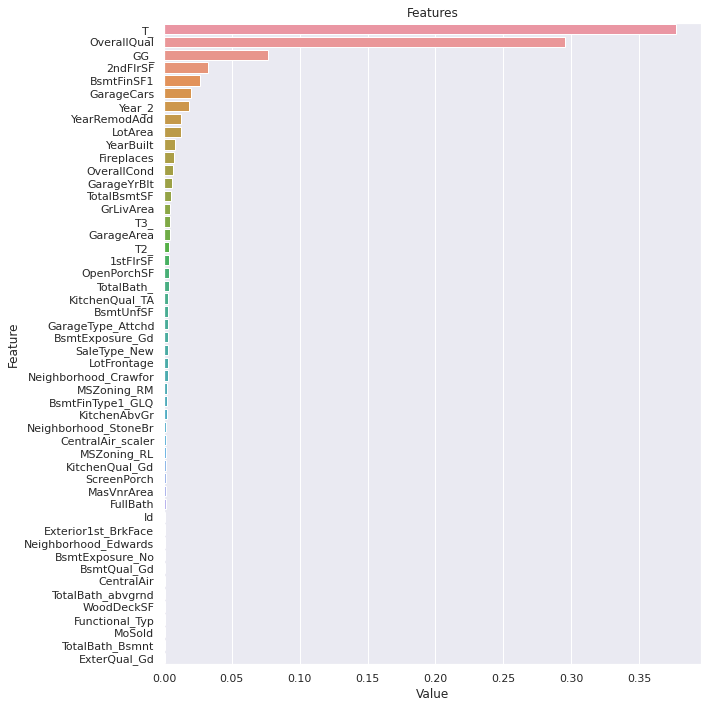

In [34]:
plot_importance(final_model, X)

In [35]:
filename = 'House Prices Predictions 1.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: House Prices Predictions 1.csv
